## 3C - L2 Camera Intrinsic and Extrinsic Parameters

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.rotations as pr
from pytransform3d.plot_utils import plot_vector

np.random.seed(42)

### Transformations

#### Rotation transformation

In [2]:
def get_rot_x(angle):
    '''
    transformation matrix that rotates a point about the standard X axis
    '''
    Rx = np.zeros(shape=(3, 3))
    Rx[0, 0] = 1
    Rx[1, 1] = np.cos(angle)
    Rx[1, 2] = -np.sin(angle)
    Rx[2, 1] = np.sin(angle)
    Rx[2, 2] = np.cos(angle)
    
    return Rx

def get_rot_y(angle):
    '''
    transformation matrix that rotates a point about the standard Y axis
    '''
    Ry = np.zeros(shape=(3, 3))
    Ry[0, 0] = np.cos(angle)
    Ry[0, 2] = -np.sin(angle)
    Ry[2, 0] = np.sin(angle)
    Ry[2, 2] = np.cos(angle)
    Ry[1, 1] = 1
    
    return Ry

def get_rot_z(angle):
    '''
    transformation matrix that rotates a point about the standard Z axis
    '''
    Rz = np.zeros(shape=(3, 3))
    Rz[0, 0] = np.cos(angle)
    Rz[0, 1] = -np.sin(angle)
    Rz[1, 0] = np.sin(angle)
    Rz[1, 1] = np.cos(angle)
    Rz[2, 2] = 1
    
    return Rz

In [3]:
def create_rotation_transformation_matrix(angles, order):
    '''
    Create a matrix that rotates a vector through the given angles in the given order
    wrt the standard global axes (extrinsic rotation)
    Note: The rotation is carried out anticlockwise in a left handed axial system
    
    Parameters
    -----------
    angles - list
        list of angles in radians
    order - string
        the order in which to rotate
        
    Returns
    --------
    net - np.ndarray, shape - (3, 3)
        The transformation matrix which carries out the given rotations
    '''
    fn_mapping = {'x': get_rot_x, 'y': get_rot_y, 'z': get_rot_z}
    net = np.identity(3)
    for angle, axis in list(zip(angles, order))[::-1]:
        if fn_mapping.get(axis) is None:
            raise ValueError("Invalid axis")
        R = fn_mapping.get(axis)
        net = np.matmul(net, R(angle))
        
    return net

In [4]:
angles = [np.pi/4, np.pi/4]
order = 'zy'
R = create_rotation_transformation_matrix(angles, order)

Text(0.5, 0, 'Z-axis')

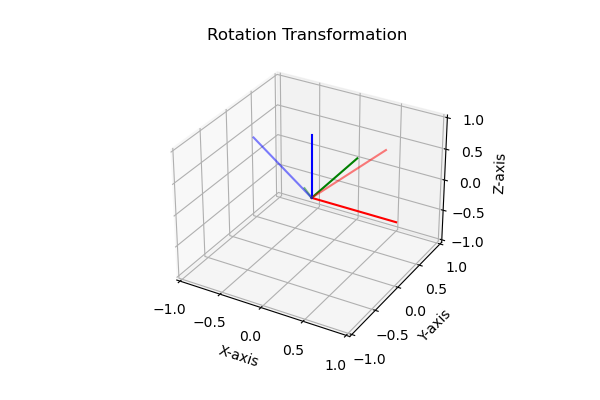

In [5]:
# create figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set axis limits
ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))

# plot the standard global basis
ax = pr.plot_basis(ax)

# plot the transformed basis
ax = pr.plot_basis(ax, R, alpha=0.5)

# set labels
ax.set_title("Rotation Transformation")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

Perfect

#### Translation transformation

In [6]:
def create_translation_matrix(offset):
    '''
    Create a transformation matrix that translates a vetor by the given offset
    
    Parameters
    -----------
    offset - np.ndarray, shape - (3,)
        The translation offset
    
    Returns
    ----------
    T - np.ndarray, shape - (4, 4)
        The translation matrix
    '''
    T = np.identity(4)
    T[:3, 3] = offset
    return T

#### Transformation Example

Let's demonstrate the transformation matrix by rotating the basis vectors an angle of $\pi/4$ along the Y axis and translating by an offset $(0, -0.5, 0)$

In [7]:
# create rotation transformation matrix
angles = [np.pi/4]
order = 'y'

R = create_rotation_transformation_matrix(angles, order)
R_ = np.identity(4)
R_[:3, :3] = R

# create translation matrix
offset = np.array([0, -0.5, 0])
T_ = create_translation_matrix(offset)

In [8]:
# basis in homogeneous coordinates
xh = np.array([1, 0, 0, 1])
yh = np.array([0, 1, 0, 1])
zh = np.array([0, 0, 1, 1])

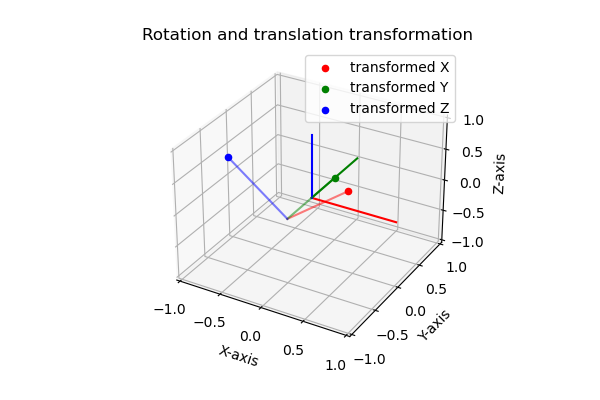

In [9]:
# create figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set axis limits
ax.set(xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))

# plot the standard global basis
ax = pr.plot_basis(ax)

# plot the transformed basis using the library
ax = pr.plot_basis(ax, R, alpha=0.5, p=offset)

# transform the basis points using the transformation matrix
xt = R_ @ T_ @ xh.reshape(4, 1)
yt = R_ @ T_ @ yh.reshape(4, 1)
zt = R_ @ T_ @ zh.reshape(4, 1)

ax.scatter(*xt.flatten()[:3], label="transformed X", color="red")
ax.scatter(*yt.flatten()[:3], label="transformed Y", color="green")
ax.scatter(*zt.flatten()[:3], label="transformed Z", color="blue")

# set labels
ax.set_title("Rotation and translation transformation")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.legend()

Perfect

### Extrinsic Camera Matrix

The extrinsic camera matrix is a change of basis matrix that lets us view the coordinates from the camera perspective.
<br> It's a combination of the rotation change of basis matrix and the translation change of basis matrix

In [10]:
def create_rotation_change_of_basis_matrix(transformation_matrix):
    '''
    Creates a rotation change of basis matrix
    '''
    # basis vectors
    x = np.array([1, 0, 0])
    y = np.array([0, 1, 0])
    z = np.array([0, 0, 1])
    
    xt = transformation_matrix.T @ x.reshape(3, 1)
    yt = transformation_matrix.T @ y.reshape(3, 1)
    zt = transformation_matrix.T @ z.reshape(3, 1)
    
    return np.hstack((xt, yt, zt))

In [11]:
Rc = create_rotation_change_of_basis_matrix(R)

#### Change of basis example

consider the point $P = [-1, 0, 1]$. In the world space, It lies on a line that makes an angle of $\pi/4$ with the positive standard Z axis. Now, if we rotate the camera by an angle of $\pi/4$ along the Y axis, then wrt to the camera, P should lie on the Z axis, and it should be of the form $[0, 0, z\prime]$. Let's validate this.

In [12]:
p = np.array([-1, 0, 1])
Rc @ p

array([0.        , 0.        , 1.41421356])

Hence validated

### Intrinsic Parameters

Intrinsic camera matrix projects a point from the camera frame onto the image plane.

We're dealing with a left handed axial system here, hence we assume the camera points towards the positive Z axis.

#### plot image plane

In [13]:
# define the focal length and the image size
f = 2 # f > 0
img_size = (7, 7)

h, w = img_size
xx, yy = np.meshgrid(range(-(h // 2), w // 2 + 1), range(-(h // 2), w // 2 + 1))
Z = np.ones(shape=img_size) * f

Text(0.5, 0, 'Z-axis')

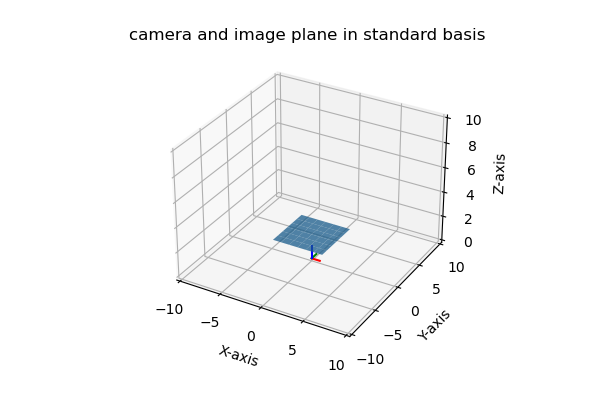

In [14]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

ax.plot_surface(xx, yy, Z, alpha=0.75)

ax.set(xlim=(-10, 10), ylim=(-10, 10), zlim=(0, 10))
ax = pr.plot_basis(ax)

ax.set_title("camera and image plane in standard basis")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

##### Transform the camera along with the image plane

The image plane is an intrinsic part of the camera; hence,| as we transform the camera the image plane transforms with it.

In [15]:
# extract points from the image plane grid
pi = np.ones(shape=(4, h*w))
c = 0
for i in range(h):
    for j in range(w):
        x = xx[i, j]
        y = yy[i, j]
        z = Z[i, j]
        point = np.array([x, y, z])
        pi[:3, c] = point
        c += 1

In [16]:
angles = [np.pi/4]
order = "y"

offset = np.array([0, -5, 0])
R = create_rotation_transformation_matrix(angles, order)
T = create_translation_matrix(offset)

In [17]:
Rh = np.identity(4) # rotation matrix in homogeneous coordinates
Rh[:3, :3] = R

In [18]:
E = Rh @ T

In [19]:
pt = np.matmul(E, pi)

In [20]:
pt.shape

(4, 49)

In [21]:
pt = pt[:3, :] # convert from homogeneous coordinates to euclidean coordinates

In [22]:
pt.shape

(3, 49)

In [23]:
# separate x, y, z and construct a grid from the transformed points
xxt = pt[0, :].reshape(img_size)
yyt = pt[1, :].reshape(img_size)
Zt = pt[2, :].reshape(img_size)

Text(0.5, 0, 'Z-axis')

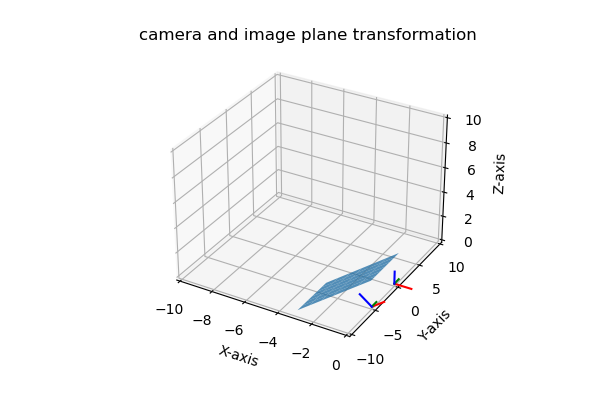

In [24]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

ax.set(xlim=(-10, 0), ylim=(-10, 10), zlim=(0, 10))

ax = pr.plot_basis(ax)

# the transformed image plane
ax.plot_surface(xxt, yyt, Zt, alpha=0.75)
# the transformed camera
ax = pr.plot_basis(ax, R, p=offset)

ax.set_title("camera and image plane transformation")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

#### Plot camera and points in the world space

In [25]:
def generate_random_points(n_points, xlim, ylim, zlim):
    x = np.random.randint(xlim[0], xlim[1], size=n_points)
    y = np.random.randint(ylim[0], ylim[1], size=n_points)
    z = np.random.randint(zlim[0], zlim[1], size=n_points)
    
    return np.vstack((x, y, z))

In [26]:
make_line = lambda u, v: np.vstack((u, v)).T

In [27]:
origin = offset

n_points = 6
xlim = (-10, 0)
ylim = (-10, 10)
zlim = (0, 10)

In [28]:
rand_points = generate_random_points(n_points, xlim, ylim, zlim)

Text(0.5, 0, 'Z-axis')

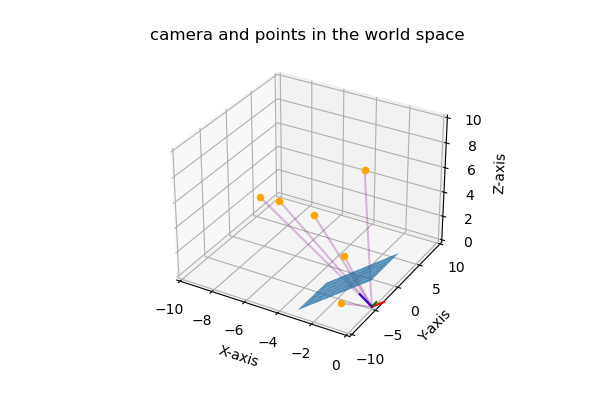

In [29]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

ax.set(xlim=(-10, 0), ylim=(-10, 10), zlim=(0, 10))

# the transformed image plane
ax.plot_surface(xxt, yyt, Zt, alpha=0.75)
# the transformed camera
ax = pr.plot_basis(ax, R, p=offset)

# plot points
for i in range(n_points):
    point = rand_points[:, i]
    ax.scatter(*point, color="orange")
    ax.plot(*make_line(origin, point), color="purple", alpha=0.25)
        
ax.set_title("camera and points in the world space")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

#### Intrinsic parameter matrix

Intrinsic camera matrix projects a point from the camera frame onto the image plane.

In the below examples, for simplicity, we'll assume the camera is positioned at the origin and is pointing towards the +ve Z axis. Essentially, we're assuming the extrinsic camera matrix is an identity matrix, and the camera is aligned with the standard basis in the world frame

In [30]:
# intrinsic parameters
f = 2
s = 0
a = 2
cx = 0
cy = 0

In [31]:
def compute_intrinsic_parameter_matrix(f, s, a, cx, cy):
    K = np.identity(3)
    K[0, 0] = f
    K[0, 1] = s
    K[0, 2] = cx
    K[1, 1] = a * f
    K[1, 2] = cy
    
    return K

In [32]:
K = compute_intrinsic_parameter_matrix(f, s, a, cx, cy)

In [33]:
K

array([[2., 0., 0.],
       [0., 4., 0.],
       [0., 0., 1.]])

#### plot square points

For simplicity we'll plot points that look like a square

In [34]:
n_points = 6
xlim = (-5, 5)
ylim = (-5, 5)
elevation = 5
x = np.linspace(xlim[0], xlim[1], n_points)
y = np.linspace(ylim[0], ylim[1], n_points)
xxs, yys = np.meshgrid(x, y)
zzs = elevation * np.ones(shape=(n_points, n_points))
square_points = np.ones(shape=(4, n_points * n_points))

In [35]:
# define image plane
img_size = (7, 7)
origin = np.array([0, 0, 0])

# assume the image plane is cenetered at the origin
h, w = img_size
xx, yy = np.meshgrid(range(-(h // 2), w // 2 + 1), range(-(h // 2), w // 2 + 1))
Z = np.ones(shape=img_size) * f

In [36]:
# transform image plane

# 1. extract points from the image plane grid
img_plane_points = np.ones((3, img_size[0] * img_size[1]))
c = 0
for i in range(img_size[0]):
    for j in range(img_size[1]):
        xi = xx[i, j]
        yi = yy[i, j]
        zi = Z[i, j]
        img_plane_points[:, c] = np.array([xi, yi, zi])
        c += 1

# 2. transform the image plane points
K_ = K.copy()
K_[:2, :2] = 1/f * K_[:2, :2]
Kinv = np.linalg.inv(K_) # the transformation matrix is the inverse of the change of basis matrix
img_plane_points_transformed = Kinv @ img_plane_points

# 3. construct the grid back from the transformed points
xx = img_plane_points_transformed[0, :].reshape(img_size[0], img_size[1])
yy = img_plane_points_transformed[1, :].reshape(img_size[0], img_size[1])
Z = img_plane_points_transformed[2, :].reshape(img_size[0], img_size[1])

In [37]:
xx

array([[-3., -2., -1.,  0.,  1.,  2.,  3.],
       [-3., -2., -1.,  0.,  1.,  2.,  3.],
       [-3., -2., -1.,  0.,  1.,  2.,  3.],
       [-3., -2., -1.,  0.,  1.,  2.,  3.],
       [-3., -2., -1.,  0.,  1.,  2.,  3.],
       [-3., -2., -1.,  0.,  1.,  2.,  3.],
       [-3., -2., -1.,  0.,  1.,  2.,  3.]])

Text(0.5, 0, 'Z-axis')

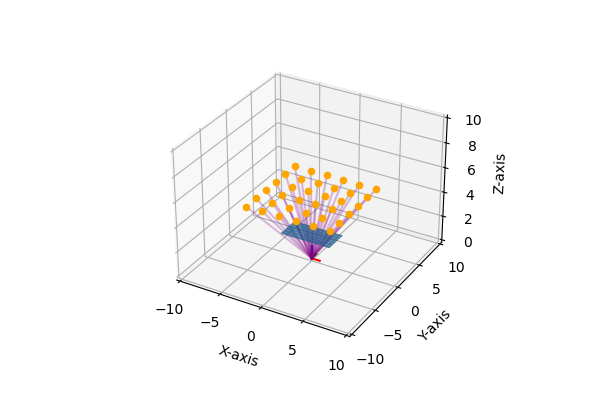

In [38]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

ax.plot_surface(xx, yy, Z, alpha=0.75)

ax.set(xlim=(-10, 10), ylim=(-10, 10), zlim=(0, 10))
ax = pr.plot_basis(ax)

# plot square points
c = 0
for i in range(n_points):
    for j in range(n_points):
        xs = xxs[i, j]
        ys = yys[i, j]
        zs = zzs[i, j]
        point = np.array([xs, ys, zs])
        square_points[:3, c] = point
        ax.scatter(*point, color="orange")
        ax.plot(*make_line(origin, point), color="purple", alpha=0.25)
        c += 1

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

In [39]:
fig.savefig('data/camera_projection.png')

In [40]:
def compute_world2img_projection(points, E, K):
        
    P = np.identity(4)[:3, :] # the projection matrix
    h_points_i = K @ P @ E @ points
    
    h_points_i[0, :] = h_points_i[0, :] / h_points_i[2, :]
    h_points_i[1, :] = h_points_i[1, :] / h_points_i[2, :]

    points_i = h_points_i[:2, :]    
    
    return points_i

In [41]:
EI = np.identity(4)

In [42]:
img = compute_world2img_projection(square_points, EI, K)

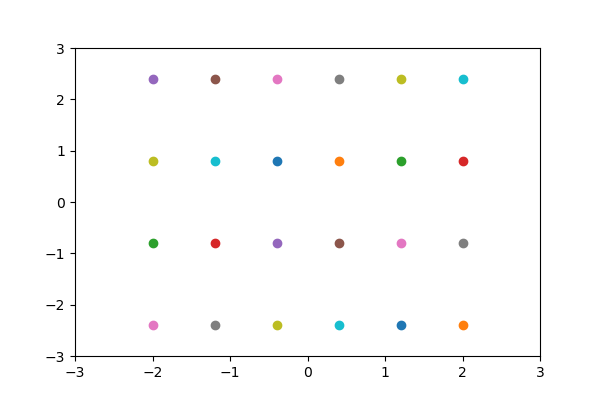

In [43]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

ax.set(xlim = (-(h // 2), w // 2), ylim = (-(h // 2), w // 2))
for i in range(n_points * n_points):
        ax.scatter(*img[:, i])